# Examining the miRNA gene Expression in Response to PT Across Time Points

## Loading the Data 

In [3]:
import pandas as pd
import numpy as np 

path = '/home/johnny.velasquez/OTP_RADGEN_CLINICALDATA_ANALYSIS/DATA_PREPROCESSING/OTP_RADIOGENOMICS_FINAL_CLINICALDATASET_DEC12_2023_V4.xlsx'
data = pd.read_excel(path)
data.head()

,SAMPLE_NO,OTP_ID,TIME_POINT,COLLECTION_DATE,MAX_PSA_PREPT,MAX_PSA_PREPT_CUTOFF,TUMOR_STAGE,PRIMARY_GLEASON,SECONDARY_GLEASON,GLEASON_SUM,...,TUMOR_STAGE_T2a,TUMOR_STAGE_T2b,TUMOR_STAGE_T1c_CONDITION,TUMOR_STAGE_T2a_CONDITION,TUMOR_STAGE_T2b_CONDITION,PRIMARY_GLEASON_CLASS,PRIMARY_GLEASON_CLASS_CONDITION,PRIMARY_GLEASON_CONDITION,PSA_PREPT_RANGES,PSA_PREPT_RANGES_CONDITION
0,1,46,PRE-RT,2010-12-28,4.0,≤4,T2b,4,4,8,...,>T2a,≤T2b,"PRE-RT, >T1c","PRE-RT, >T2a","PRE-RT, ≤T2b",≥4,"PRE-RT, Primary Gleason Range: ≥4","PRE-RT, Primary Gleason Score: 4",Normal,"PRE-RT, PSA PREPT as Normal"
1,2,46,4WKSPD1,2011-01-26,4.0,≤4,T2b,4,4,8,...,>T2a,≤T2b,"4WKSPD1, >T1c","4WKSPD1, >T2a","4WKSPD1, ≤T2b",≥4,"4WKSPD1, Primary Gleason Range: ≥4","4WKSPD1, Primary Gleason Score: 4",Normal,"4WKSPD1, PSA PREPT as Normal"
2,3,46,8WKSPD1,2011-02-22,4.0,≤4,T2b,4,4,8,...,>T2a,≤T2b,"8WKSPD1, >T1c","8WKSPD1, >T2a","8WKSPD1, ≤T2b",≥4,"8WKSPD1, Primary Gleason Range: ≥4","8WKSPD1, Primary Gleason Score: 4",Normal,"8WKSPD1, PSA PREPT as Normal"
3,4,72,PRE-RT,2012-04-16,9.8,>4,T1c,5,4,9,...,≤T2a,≤T2b,"PRE-RT, T1c","PRE-RT, ≤T2a","PRE-RT, ≤T2b",≥4,"PRE-RT, Primary Gleason Range: ≥4","PRE-RT, Primary Gleason Score: 5",Elevated,"PRE-RT, PSA PREPT as Elevated"
4,5,72,4WKSPD1,2012-05-14,9.8,>4,T1c,5,4,9,...,≤T2a,≤T2b,"4WKSPD1, T1c","4WKSPD1, ≤T2a","4WKSPD1, ≤T2b",≥4,"4WKSPD1, Primary Gleason Range: ≥4","4WKSPD1, Primary Gleason Score: 5",Elevated,"4WKSPD1, PSA PREPT as Elevated"


## Testing for Normal Distribution and Homogeneity of Variance 

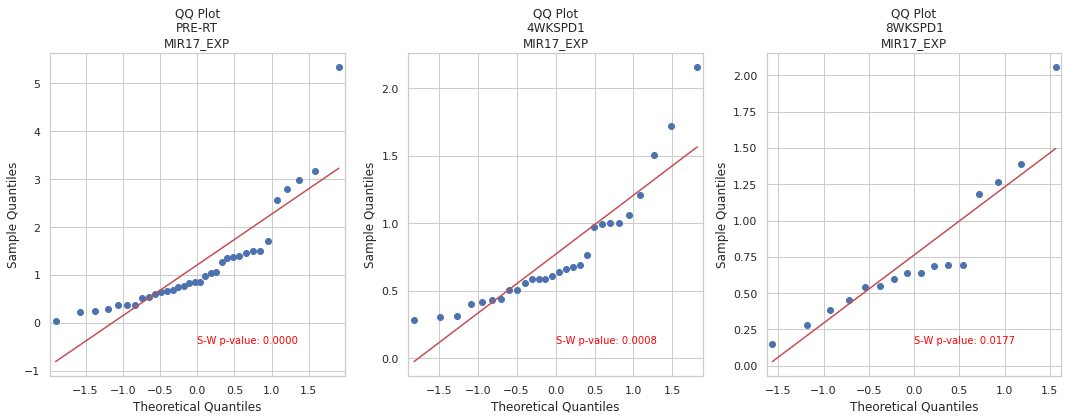

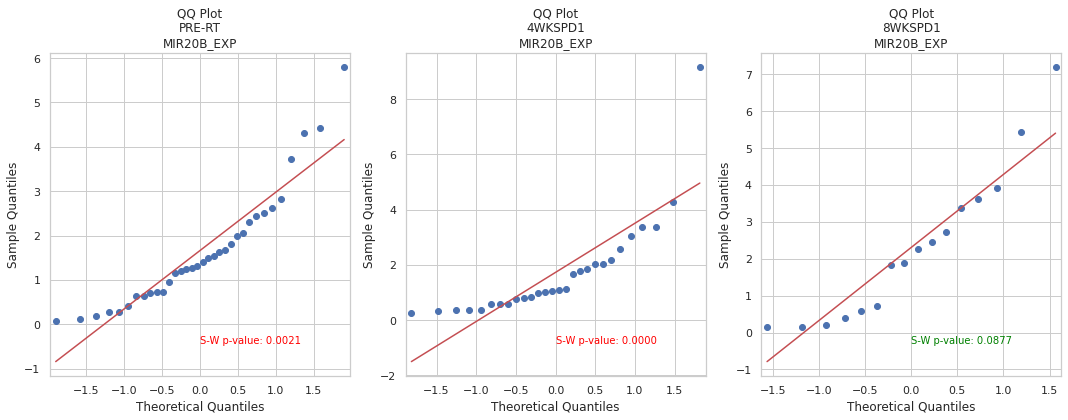

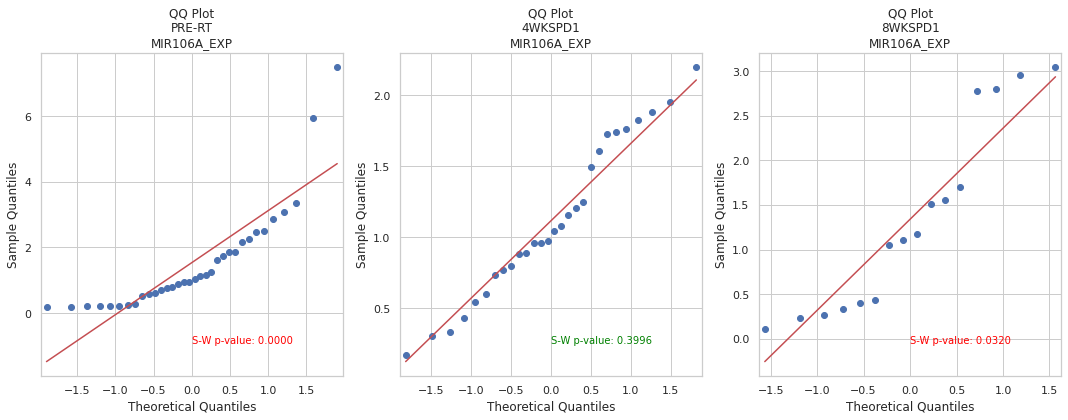

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats

def analyze_gene(data, gene_name, hue_by, condition_order):
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
    axes = axes.flatten()
    for idx, condition in enumerate(condition_order):
        ax = axes[idx]
        subset_data = data[data[hue_by] == condition]
        # Check if the subset data has at least 3 data points
        if len(subset_data[gene_name]) < 3:
            ax.set_title(f'Not enough data for {gene_name}\n{condition}')
            continue
        sm.qqplot(subset_data[gene_name], line='s', ax=ax)
        ax.set_title(f'QQ Plot\n{condition}\n{gene_name}')
        # Perform Shapiro-Wilk test
        shapiro_test_stat, shapiro_p_value = stats.shapiro(subset_data[gene_name])
        color = 'red' if shapiro_p_value < 0.05 else 'green'
        ax.text(0.5, 0.1, f'S-W p-value: {shapiro_p_value:.4f}', transform=ax.transAxes, fontsize=10, color=color)
    plt.tight_layout()
    plt.savefig(f'{gene_name}_QQPLOT.png', format='png', dpi=600, bbox_inches='tight')
    plt.show()

# Specify the genes you want to analyze
genes_to_analyze = ['MIR17_EXP', 'MIR20B_EXP', 'MIR106A_EXP']  # Add more genes as needed
#Specify the phenotype you want to analyze
hue_by = 'TIME_POINT'
# Specify the order of sample conditions
condition_order = ["PRE-RT", "4WKSPD1", "8WKSPD1"]

# Call the function for each gene
for gene in genes_to_analyze:
    analyze_gene(data, gene, hue_by, condition_order)

In [7]:
import pandas as pd
import numpy as np
from scipy.stats import levene

def run_levene_test(dataframe, gene_to_analyze, timepoints_column):
    timepoints = np.unique(dataframe[timepoints_column])
    data_levene = []
    for tp in timepoints:
        subset = dataframe[(dataframe[timepoints_column] == tp)][gene_to_analyze].values
        data_levene.append(subset)
    statistic, p_values = levene(*data_levene)
    print(f'Test Statistics: {round(statistic, 4)}')
    print(f'p-values: {round(p_values, 4)}')
    if p_values < 0.05:
        print('Variance between groups is HETEROGENEOUS')
    else:
        print('Variance between groups is HOMOGENEOUS')

path = '/home/johnny.velasquez/OTP_RADGEN_CLINICALDATA_ANALYSIS/DATA_PREPROCESSING/OTP_RADIOGENOMICS_FINAL_CLINICALDATASET_DEC12_2023_V4.xlsx'
data = pd.read_excel(path)
mirnas = ["MIR17_EXP", "MIR20B_EXP", "MIR106A_EXP"]

for mirna in mirnas:
    print(f'Levene Test for {mirna}')
    run_levene_test(dataframe = data, gene_to_analyze = mirna, timepoints_column = "TIME_POINT")
    if mirna != "MIR106A_EXP":
        print("\n")
        print("\n")

Levene Test for MIR17_EXP
Test Statistics: 3.3476
p-values: 0.0405
Variance between groups is HETEROGENEOUS




Levene Test for MIR20B_EXP
Test Statistics: 1.262
p-values: 0.289
Variance between groups is HOMOGENEOUS




Levene Test for MIR106A_EXP
Test Statistics: 2.9745
p-values: 0.0571
Variance between groups is HOMOGENEOUS


## Descriptive Statistics on miRNA Gene Expression for Each Time Point

In [8]:
# Load the data
import pandas as pd
import numpy as np 
from datetime import datetime

path = '/home/johnny.velasquez/OTP_RADGEN_CLINICALDATA_ANALYSIS/DATA_PREPROCESSING/OTP_RADIOGENOMICS_FINAL_CLINICALDATASET_DEC12_2023_V4.xlsx'
data = pd.read_excel(path)
current_date = datetime.now().strftime('%Y_%m_%d')
column = "TIME_POINT"

# Perform descriptive statistics on the data frame
miRNA_exp_descr_stats = data.groupby(['TIME_POINT'], sort=False)[['MIR17_EXP', 'MIR20B_EXP', 'MIR106A_EXP']].describe()
# Round the values to a specific number of decimals
miRNA_exp_descr_stats = miRNA_exp_descr_stats.round(decimals=3)
# Reset index to make the DataFrame more readable in the output
miRNA_exp_descr_stats.reset_index(inplace=True)
outputfile_name = f'{current_date}_{column}_DESCRIPTIVE_STATS.xlsx'
# Save the result to a CSV file
miRNA_exp_descr_stats.to_excel(outputfile_name, index=True)
### Download and format in excel independently

## Visualizing the Data with Kruskal-Wallis Test Result Annotations

In [15]:
# Import Libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations 
from statannotations.Annotator import Annotator


# Load the data
path = "/home/johnny.velasquez/OTP_RADGEN_CLINICALDATA_ANALYSIS/DATA_PREPROCESSING/OTP_RADIOGENOMICS_FINAL_CLINICALDATASET_DEC12_2023_V4.xlsx"
data = pd.read_excel(path)

tps = list(["PRE-RT", "4WKSPD1", "8WKSPD1"])
tp_pairs = list(combinations(tps, r=2))

# Begin Plotting
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(30, 8), dpi=600)
sns.set(style="whitegrid")
genes_to_plot = ['MIR17_EXP', 'MIR20B_EXP', 'MIR106A_EXP'] 
custom_palette = {"PRE-RT": "#F5F5F5", "4WKSPD1": "#F5F5F5", "8WKSPD1": "#F5F5F5"}
PROPS = {'boxprops': {'edgecolor': 'black'}, 'whiskerprops': {'color': 'black'}, 'capprops': {'color': 'black'}}
flierprops = dict(markerfacecolor='grey', markersize=5, markeredgecolor='black')

for idx, gene in enumerate(genes_to_plot):
    sns.boxplot(x="TIME_POINT", y=gene, data=data, order=["PRE-RT", "4WKSPD1", "8WKSPD1"],
                palette=custom_palette, showmeans=False, showfliers=False,
                meanprops={"marker": "s", "markerfacecolor": "black", "markersize": 5, "markeredgecolor": "black"},
                linewidth=1.5, medianprops=dict(color="black"), flierprops=flierprops, **PROPS, ax=axs[idx])

    sns.swarmplot(x="TIME_POINT", y=gene, data=data, order=["PRE-RT", "4WKSPD1", "8WKSPD1"], 
                  palette=custom_palette, dodge=True, size=5, linewidth=0.5, edgecolor="black", ax=axs[idx])

    # Add Annotations
    annotator = Annotator(ax=axs[idx], pairs=tp_pairs, data=data, x="TIME_POINT", y=gene, order=["PRE-RT", "4WKSPD1", "8WKSPD1"],
                          palette=custom_palette)
    
    annotator.configure(test="Kruskal", verbose = True).apply_and_annotate() # comparisons_correction="Bonferroni"
    
    labels = [item.get_text() for item in axs[idx].get_xticklabels()]
    labels[0] = 'PRE-PT'
    labels[1] = '4WKSPD1'
    labels[2] = '8WKSPD1'
    axs[idx].set_xticklabels(labels, family="serif")
    axs[idx].set_yticklabels(axs[idx].get_yticklabels(), family="serif")

    axs[idx].xaxis.tick_top()
    axs[idx].xaxis.tick_bottom()
    axs[idx].tick_params(axis='x', labelsize=9, labelrotation=0)
    axs[idx].tick_params(axis='y', labelsize=9)

    axs[idx].set_xlabel('Time Point', family="serif", fontsize=12)
    axs[idx].set_ylabel('Gene Expression Fold Change', family="serif", fontsize=12)
    variable = gene
    result = variable.split('_')[0]
    axs[idx].set_title(result, family="serif")



p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PRE-RT vs. 4WKSPD1: Kruskal-Wallis independent samples (pairwise between groups), P_val:1.053e-01 Stat=2.623e+00
4WKSPD1 vs. 8WKSPD1: Kruskal-Wallis independent samples (pairwise between groups), P_val:9.805e-01 Stat=5.953e-04
PRE-RT vs. 8WKSPD1: Kruskal-Wallis independent samples (pairwise between groups), P_val:1.316e-01 Stat=2.274e+00


/scratch/local/18029188/ipykernel_586093/2101754524.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[idx].set_yticklabels(axs[idx].get_yticklabels(), family="serif")


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PRE-RT vs. 4WKSPD1: Kruskal-Wallis independent samples (pairwise between groups), P_val:7.773e-01 Stat=8.003e-02
4WKSPD1 vs. 8WKSPD1: Kruskal-Wallis independent samples (pairwise between groups), P_val:4.208e-01 Stat=6.482e-01
PRE-RT vs. 8WKSPD1: Kruskal-Wallis independent samples (pairwise between groups), P_val:4.173e-01 Stat=6.579e-01


/scratch/local/18029188/ipykernel_586093/2101754524.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[idx].set_yticklabels(axs[idx].get_yticklabels(), family="serif")


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PRE-RT vs. 4WKSPD1: Kruskal-Wallis independent samples (pairwise between groups), P_val:8.541e-01 Stat=3.381e-02
4WKSPD1 vs. 8WKSPD1: Kruskal-Wallis independent samples (pairwise between groups), P_val:8.262e-01 Stat=4.821e-02
PRE-RT vs. 8WKSPD1: Kruskal-Wallis independent samples (pairwise between groups), P_val:9.585e-01 Stat=2.703e-03


/scratch/local/18029188/ipykernel_586093/2101754524.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[idx].set_yticklabels(axs[idx].get_yticklabels(), family="serif")


## Manual Programming of the Post-Hoc Test

In [43]:
import pandas as pd
import numpy as np 
from scipy import stats 
import scikit_posthocs as sp

# Define Kruskal Wallis Test 
def run_kruskal_group2(dataframe, miRNA_col, tp_col):
    tp = np.unique(data[tp_col])
    subset_data = [dataframe[dataframe[tp_col] == t][miRNA_col] for t in tp]
    kruskwall, p_value = stats.kruskal(*subset_data)
    print(f"Kruskal-Wallis Test Result for {miRNA_col} Across Time Points")
    print(f'Test Statistic: {round(kruskwall, 4)}')
    print(f'p-value: {round(p_value, 4)}')
    post_df = sp.posthoc_dunn(subset_data, val_col=miRNA_col, group_col=tp_col)
    print(f"Post-Hoc Test Result for {miRNA_col} Across Time Points")
    print(f'{round(post_df, 4)}')


# Import the Data
data = pd.read_excel("/home/johnny.velasquez/OTP_RADGEN_CLINICALDATA_ANALYSIS/DATA_PREPROCESSING/OTP_RADIOGENOMICS_FINAL_CLINICALDATASET_DEC12_2023_V4.xlsx")

column1 = "TIME_POINT"
genes = ["MIR17_EXP", "MIR20B_EXP", "MIR106A_EXP"]

for miRNA in genes:
    run_kruskal_group2(dataframe=data, miRNA_col=miRNA, tp_col=column1)
    print("\n")


Kruskal-Wallis Test Result for MIR17_EXP Across Time Points
Test Statistic: 3.5531
p-value: 0.1692
Post-Hoc Test Result for MIR17_EXP Across Time Points
        1       2       3
1  1.0000  0.9614  0.0960
2  0.9614  1.0000  0.1468
3  0.0960  0.1468  1.0000


Kruskal-Wallis Test Result for MIR20B_EXP Across Time Points
Test Statistic: 0.847
p-value: 0.6547
Post-Hoc Test Result for MIR20B_EXP Across Time Points
        1       2       3
1  1.0000  0.3680  0.8176
2  0.3680  1.0000  0.4615
3  0.8176  0.4615  1.0000


Kruskal-Wallis Test Result for MIR106A_EXP Across Time Points
Test Statistic: 0.0561
p-value: 0.9724
Post-Hoc Test Result for MIR106A_EXP Across Time Points
        1       2       3
1  1.0000  0.8322  0.8499
2  0.8322  1.0000  0.9524
3  0.8499  0.9524  1.0000




In [26]:
tp = np.unique(data["TIME_POINT"])
print(tp)

['4WKSPD1' '8WKSPD1' 'PRE-RT']
